# Training a Conditional-GAN with CIFAR-10 dataset

Start by importing pytorch and other helpful modules.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# For plotting:
import matplotlib.pyplot as plt

# For displaying images:
from IPython.display import Image, display, clear_output

Make sure to use CUDA if available.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__, device)

1.2.0.dev20190805 cuda


In [3]:
# Create a dummy output folder:
import os

OUTPUT_DIR = 'output'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## 1. Data Loader

CIFAR10 dataset needs to be downloaded, if it doesn't exist already. The dataset consists of large number of labelled images. Each image consists of three channels (R, G, B).

Before processing, each channel of the input images are normalized to range $[-1, 1]$. The images are also resized to size $32 \times 32$.

In [4]:
dataset = dset.CIFAR10(root="./data", download=True,
                       transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

0.0%

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data


The data loader is created to help iterate through the training images. For each epoch during training, a batch of $128$ images will be used. The batches will have reshuffled data at every epoch. To speed up the loading process a bit, two subprocesses (workers) will be created.

In [5]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

# 2. Architecture

A Generative Adversial Network (GAN) consists of two competiting neural networks, where the discriminator is trained to detect fake images and the generator is trained to create fake images which are good enough to fool the discriminator. With sufficiently good discriminator, the generator will also be good.

While the generator of a normal GAN takes a random noise vector and maps it to an image, the generator of a conditional GAN also take an additional input in the form of a *label* and outputs an image corresponding to that *label*. For example, if the additional input is the label for *train*, it outputs an image of the train. For this, both the discriminator and the generator needs to take additional inputs to represent the *condition*. An overview of this architecture is shown below:

<img src="arch.jpeg" width="640px">

Since the GAN will be dealing with images, it is appropriate to use Convolutional Neural Networks because the convolutional layers are well known for being able to learn image processing capabilities. I am basing my architecture on the paper [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) which shows how Deep Convolutional GANs can do pretty good jobs in generating fake images.

The DCGAN paper suggests to initialize the weights of both the generator and the discriminator with $mean=0.0$ and $stdev=0.02$. So the `weight_init` function is created to perform this initialization.

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 2.1 Generator

The generator is responsible for generating a fake image. It takes some noise vector of fixed size and a label (in the form of one-hot vector). It then maps that noise vector to an image corresponding to that label. Our goal is to ultimately have the generator be able to generate images that look similar to the images from the CIFAR-10 dataset.

The architecture of the generator, based on DCGAN, consists of several Tranposed-Convolutional layers, along with batch normalizations. `ReLu` activation functions are used except in the final layer, which uses `tanh` function to generate images, normalized in the range $[-1, 1]$.

Note that in the initial layer, we need to concatenate the inputs for *condition* and *noise vector*.

In [7]:
class Generator(nn.Module):
    def __init__(self, input_size=100, label_size=10, out_size=32, out_channels=3):
        super().__init__()
        
        # For consistency, we are assuming that all input tensors
        # including noise, labels are images are of shape [B x C x W x H]
        # where B is batch, C is channel, W is width and H is height.
        # For noise and labels, width and height are assumed to be 1x1.
        
        self.network = nn.Sequential(
            nn.ConvTranspose2d(label_size + input_size, out_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(out_size * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(out_size * 8, out_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_size * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(out_size * 4, out_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_size * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(out_size * 2, out_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_size),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(out_size, out_channels, 1, 1, 0, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input, label):
        # Concat the input with the label before feeding to the network.
        return self.network(torch.cat([input, label], 1))


Create the actual generator and initialize its weights.

In [8]:
generator = Generator().to(device)
generator.apply(weights_init)

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(110, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Tanh()
  )
)

### 2.2 Discriminator

The discriminator takes an input image, along with its label (in the form of one-hot vector) and outputs the probability of the input being true input. A true input is the one where the image is real and belongs to the specified label. It is nothing more than a Convolutional Neural Network for classification, which uses Sigmoid in the last layer to output the probability.

Just like the generator, the discriminator will also take a combination of input and condition. But since the input in this case is an image and the condition is a one-hot vector of different size, direct concatenation is not possible. So, in the following example, the label vector is first transformed using a fully-connected network to an image of same size as the input image ($32 \times 32$) and then concatenated as an additional channel to the input image. This way, the rest of the discriminator is a simple convolutional neural network that takes input with $4$ channels, where one of the channels represents the *condition*.

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=3, input_size=32, label_size=10):
        super().__init__()
        
        # Fully connected layer to transform the label vector
        # to a new channel for the input image.
        # We need to create a vector of size 32x32.
        self.label_network = nn.Sequential(
            nn.Linear(label_size, input_size * input_size),
            nn.ReLU(True),
        )

        # Note that the input channels is incremented by 1
        # to represent the "condition" input.
        self.network = nn.Sequential(
            nn.Conv2d(input_channels + 1, input_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(input_size, input_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(input_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(input_size * 2, input_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(input_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(input_size * 4, input_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(input_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(input_size * 8, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input, label):
        # First transform the label to a vector of size 32 x 32.
        # To use with linear layer, the label should of shape (BATCH_SIZE X LABEL_DIM).
        c = self.label_network(label.view(-1, label.shape[1]))
        
        # Now, reshape the "condition" channel to the shape of the image: (B X C X W X H) where C = 1 for single channel.
        c = c.view(-1, 1, input.shape[2], input.shape[3])
        
        # Concat this channel to the input image, obtaining 4 channels.
        x = torch.cat([input, c], dim=1)
        
        # Feed to the network.
        y = self.network(x)
        
        # We only want one input per batch. Reshape.
        return y.view(-1, 1)

Create the discriminator and initialize its weights.

In [10]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (label_network): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
  )
  (network): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(25

# 3. Training

Now that both the generator and the discriminator are ready, we can connect them and train them using GAN training algorithm. The idea is to continuously train both the discriminator and the generator. The discriminator is trained to properly detect real and fake images and thus the best discriminator becomes an estimate of the divergence between the distribution of the generated fake images and the distribution of the real images. The generator is trained to fool the discriminator by minimizing that divergence. The training becomes a sort of min-max game.

In [11]:
# Loss is calculated based on Cross-Entropy.
loss = nn.BCELoss()

# Learning Rate:
lr = 0.0002

# The optimizers to update the gradients.
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [12]:
# Create a function to generate the one-hot vector from a vector of labels.
# The input labels is a list of integers representing the class for each data item.
def one_hot(labels):
    # Note the need to reshape to the form (B x C x W x H) for consistent input.
    return torch.eye(10)[labels].view(-1, 10, 1, 1)

In [13]:
# Create a function to generate random noise vector.
# The result is shaped just like the one-hot vector above.
def gen_noise(batch_size, noise_dim):
    return torch.randn(batch_size, noise_dim, 1, 1, device=device)

In [14]:
# This fixed noise vector will be used during training
# to generate and save the fake images so that
# we can see the progress of fake images as we train.
fixed_noise = gen_noise(50, 100)
# Labels of the images that we want to generate:
fixed_label = one_hot(torch.LongTensor((list(range(10))*5))).to(device)

# NUMBER OF EPOCHS
num_epochs = 300

# Number of times Discriminator is trained before training Generator
k = 5

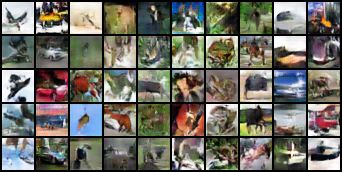

In [ ]:
# Train for several epochs.
for epoch in range(0, num_epochs):
    # Get the training data from the dataloader.
    for i, data in enumerate(dataloader, 0):
        print('Epoch', epoch, 'Batch', i, end='\r')
        
        # Get the input images and their corresponding labels.
        # The labels need to be one-hot vectors.
        train_x, train_y = data
        true_labels = one_hot(train_y)
        
        # If using CUDA, transfer to GPU.
        true_x = train_x.to(device)
        true_labels = true_labels.to(device)
        
        # To calculate loss, we want target vectors:
        
        batch_size = true_x.size(0)
        # Target vectors containing all 1's.
        true_y = torch.full((batch_size,), 1, device=device)
        # Target vectors containing all 0's.
        false_y = torch.full((batch_size,), 0, device=device)
        
        # Training discriminator.
        # Note that discriminator is trained several times before
        # training the generator once.

        # Zero out the gradients.
        discriminator.zero_grad()

        # Feed in the real images. The target vectors are all 1's.
        y = discriminator(true_x, true_labels)
        error1 = loss(y, true_y)

        # Random noise using normal distribution.
        noise = gen_noise(batch_size, 100)
        # And random labels.
        noise_labels = one_hot(torch.randint(10, (batch_size,))).to(device)
        # Use the random input to generate some fake images.
        fake_x = generator(noise, noise_labels)

        # Feed in the fake images. The target vectors are all 0's.
        y = discriminator(fake_x.detach(), noise_labels.detach())
        error2 = loss(y, false_y)

        # The total loss.
        error = error1 + error2
        # Back-propagate the error gradient.
        error.backward()

        # Update the weights of the discriminator.
        optimizerD.step()
        
        # Training generator in every k-th iteration
        if i % k == 0:
            # Zero out the gradients.
            generator.zero_grad()

            # Generate some fakes images and feed to the discriminator.
            noise = gen_noise(batch_size, 100)
            noise_labels = one_hot(torch.randint(10, (batch_size,))).to(device)
            fake_x = generator(noise, noise_labels)
            y = discriminator(fake_x, noise_labels)

            # We actually want to fool the discriminator.
            # So the target vectors for the fake images are now all 1's.
            error = loss(y, true_y)

            # Back-propagate the error gradient to the generator layers.
            error.backward()

            # Update the weights of the generator.
            optimizerG.step()
        
        # Every 100-th epoch, we will save the generated fake image
        # to see the progress.
        if i % 100 == 0:
            print('Epoch', epoch, 'Batch', i, '... Saving')
            
            # Permanently save at the beginning of every epoch.
            if i == 0:
                filename = 'fake_{:04d}.png'.format(epoch)
            else:
                filename = 'tmp.png'
                
            filename = os.path.join(OUTPUT_DIR, filename)
            
            fake_image = generator(fixed_noise, fixed_label).detach()
            vutils.save_image(fake_image, filename, nrow=10, normalize=True)
            
            clear_output(wait=True)
            display(Image(filename))
        
# After everything is done, preview the final generated images.
fake_image = generator(fixed_noise, fixed_label).detach()
filename = os.path.join(OUTPUT_DIR, 'final.png')
vutils.save_image(fake_image, filename, nrow=10, normalize=True)

clear_output(wait=True)
display(Image(filename))
print('Done')
        

# Results

Test the GAN with different random vectors and see how well it does.

In [19]:
cifar_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

airplane


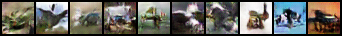

automobile


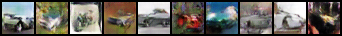

bird


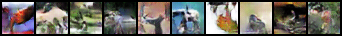

cat


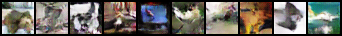

deer


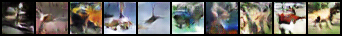

dog


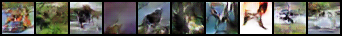

frog


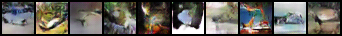

horse


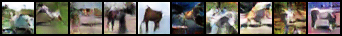

ship


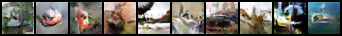

truck


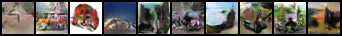

In [20]:
for i in range(10):
    print(cifar_labels[i])
    filename = os.path.join(OUTPUT_DIR, 'tmp.png')
    
    x = gen_noise(10, 100)
    y = one_hot(torch.LongTensor([i] * 10)).to(device)
    fake_image = generator(x, y).detach()
    vutils.save_image(fake_image, filename, nrow=32, normalize=True)
    display(Image(filename))

Not good enough but it looks like it's making progress. If trained for several thousand iterations, it can possible generate much better images.